In [1]:
import os
import sys
sys.path.append(os.path.abspath(".."))
from dsrag.knowledge_base import KnowledgeBase
from dsrag.llm import AzureOpenAIChatAPI
from dsrag.embedding import AzureOpenAIEmbedding
from dsrag.reranker import AzureCohereReranker
from dsrag.chat.chat import create_new_chat_thread, get_chat_thread_response
from dsrag.database.chat_thread.basic_db import BasicChatThreadDB
from dsrag.chat.chat_types import ChatResponseInput

import logging
from dotenv import load_dotenv
load_dotenv()

logging.basicConfig(
    level=logging.DEBUG,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)

2025-06-13 12:55:38,301 - dsrag.ingestion - INFO - Starting document ingestion
2025-06-13 12:55:38,302 - dsrag.ingestion - DEBUG - Ingestion parameters
2025-06-13 12:55:38,303 - dsrag.dsparse - INFO - Starting document parsing and chunking
2025-06-13 12:55:38,303 - dsrag.dsparse - DEBUG - Parse and chunk configuration
2025-06-13 12:55:38,304 - dsrag.dsparse - INFO - Using VLM file parsing
2025-06-13 12:55:38,304 - dsrag.dsparse - DEBUG - Starting VLM file parsing
2025-06-13 12:55:38,321 - dsrag.dsparse.vlm_file_parsing - DEBUG - Converting pages 1 to 100
2025-06-13 12:55:40,129 - dsrag.dsparse.vlm_file_parsing - DEBUG - Converted pages 1 to 8
2025-06-13 12:55:40,129 - dsrag.dsparse.vlm_file_parsing - INFO - Converted total 8 pages to images
2025-06-13 12:55:40,131 - dsrag.dsparse.vlm_file_parsing - DEBUG - Starting VLM page processing with up to 5 concurrent requests
2025-06-13 12:55:40,224 - PIL.PngImagePlugin - DEBUG - STREAM b'IHDR' 16 13
2025-06-13 12:55:40,226 - PIL.PngImagePlugin
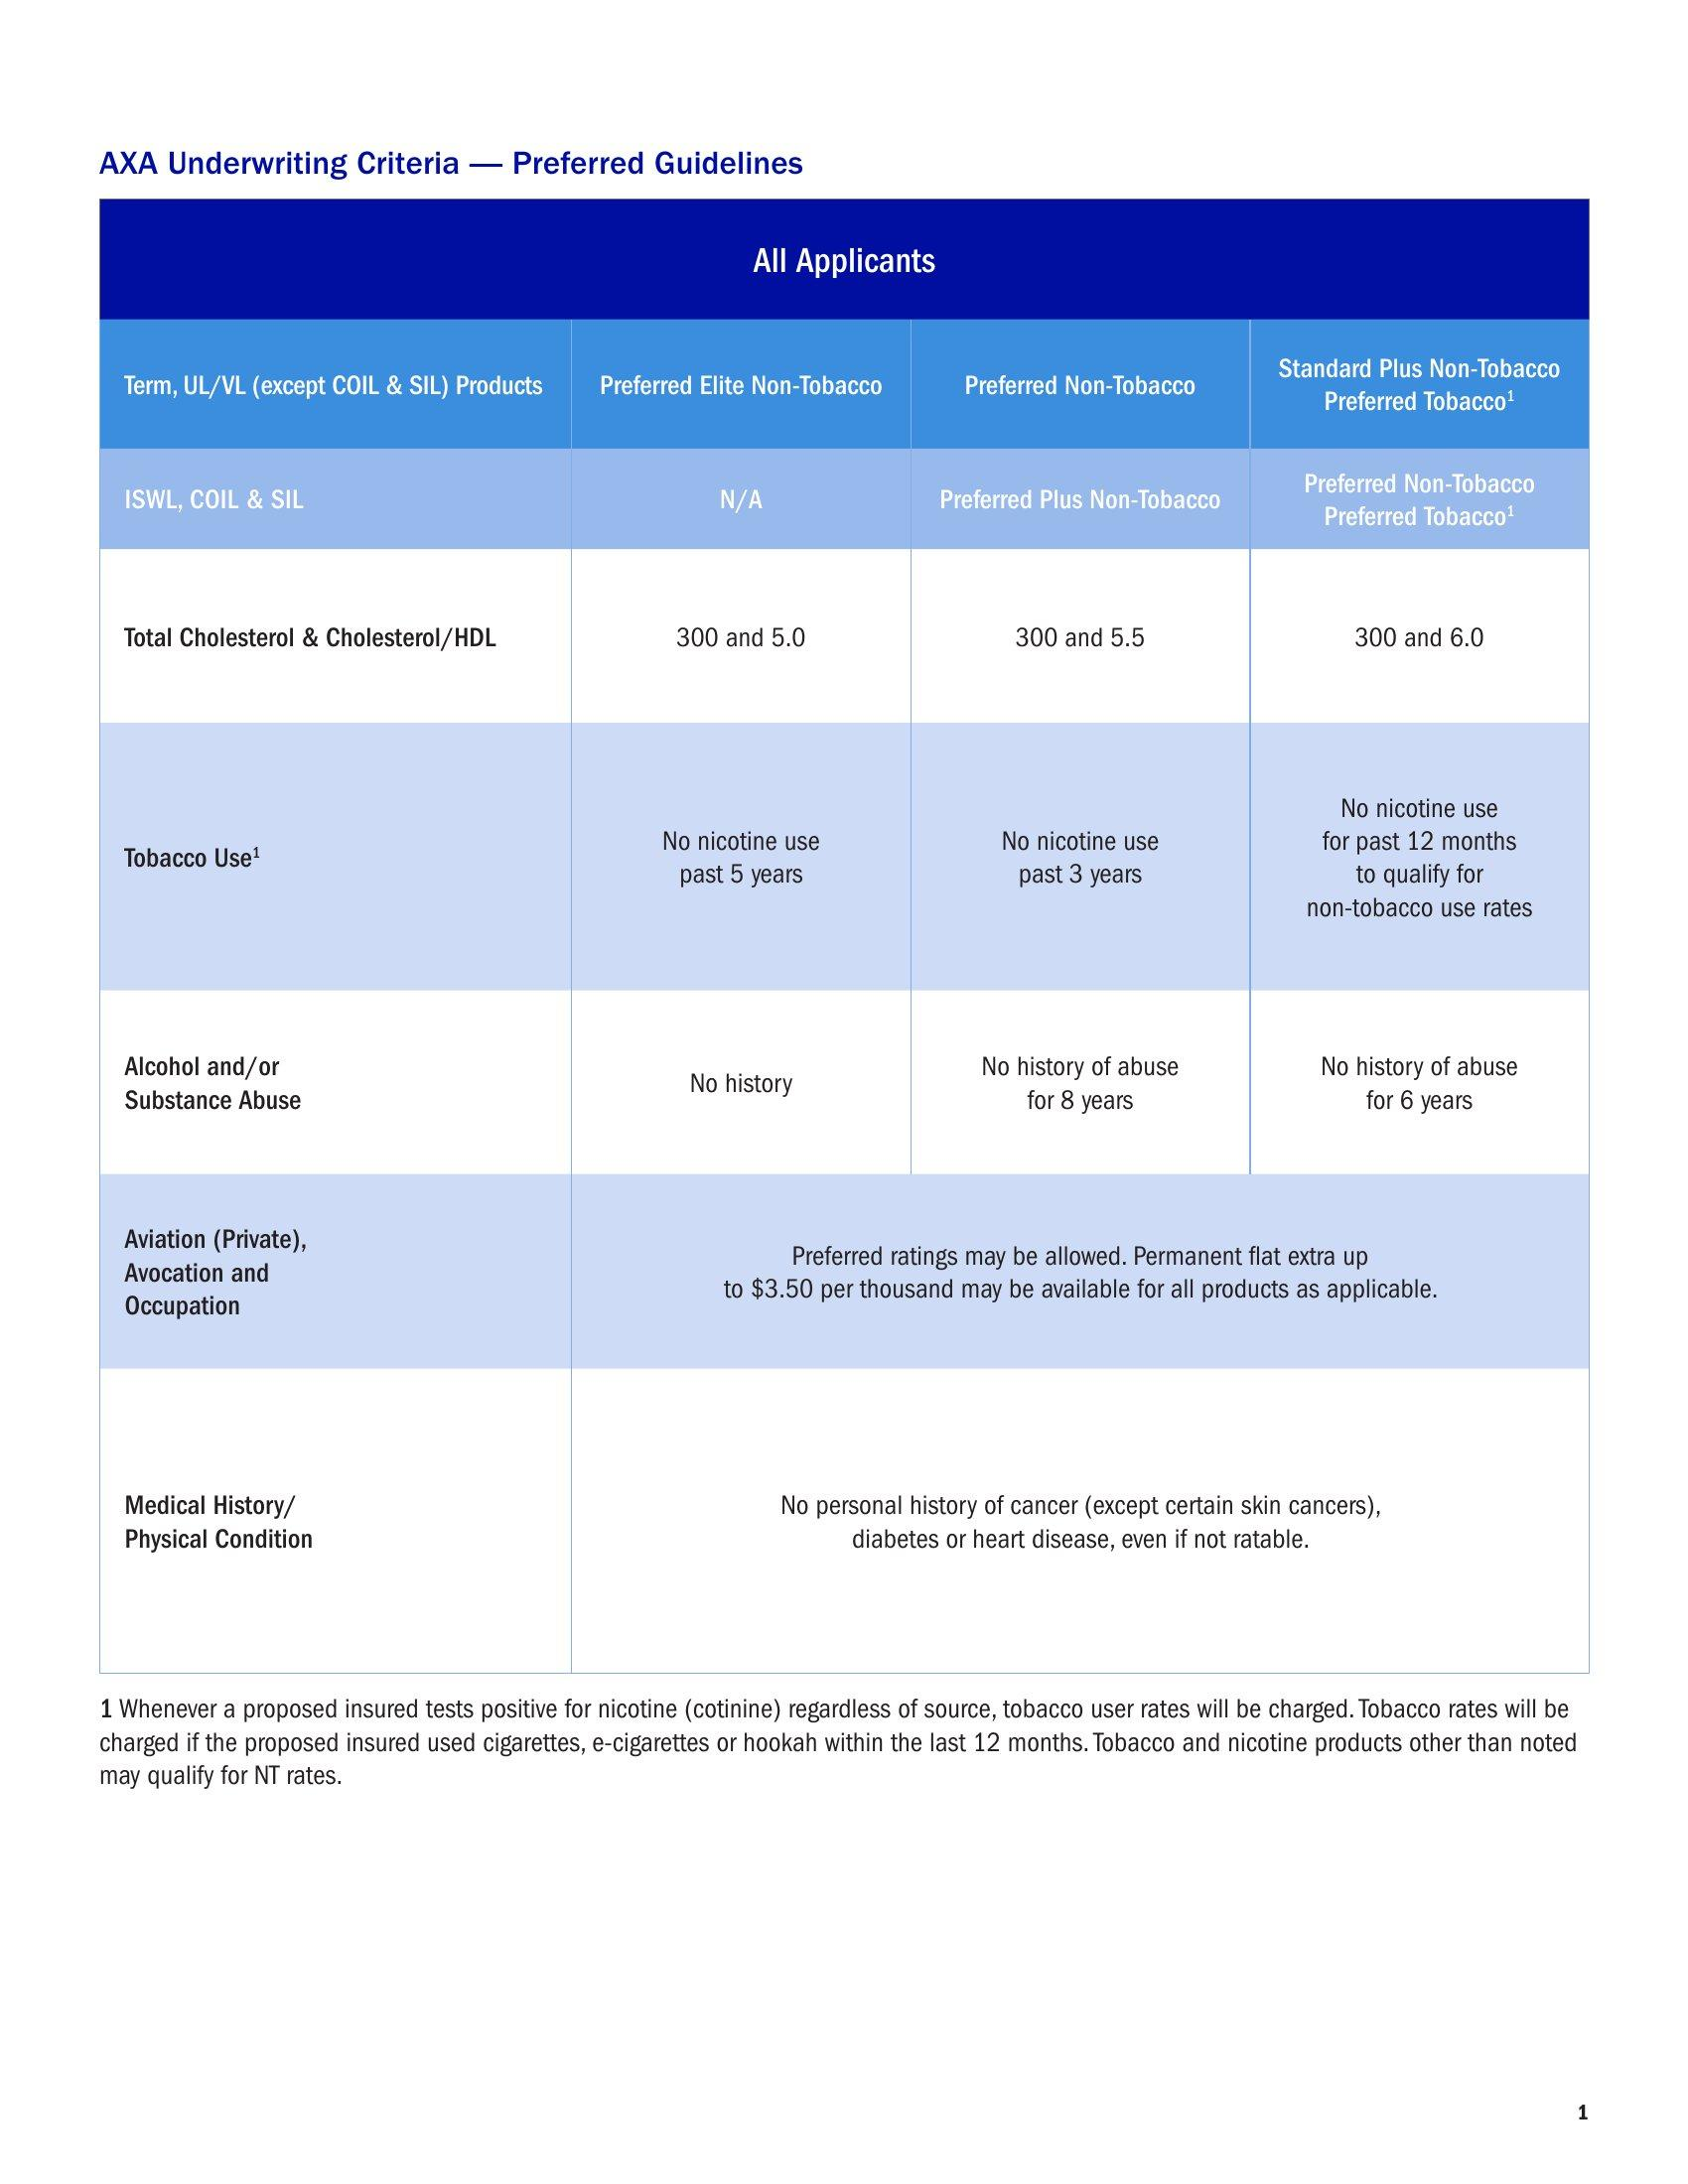
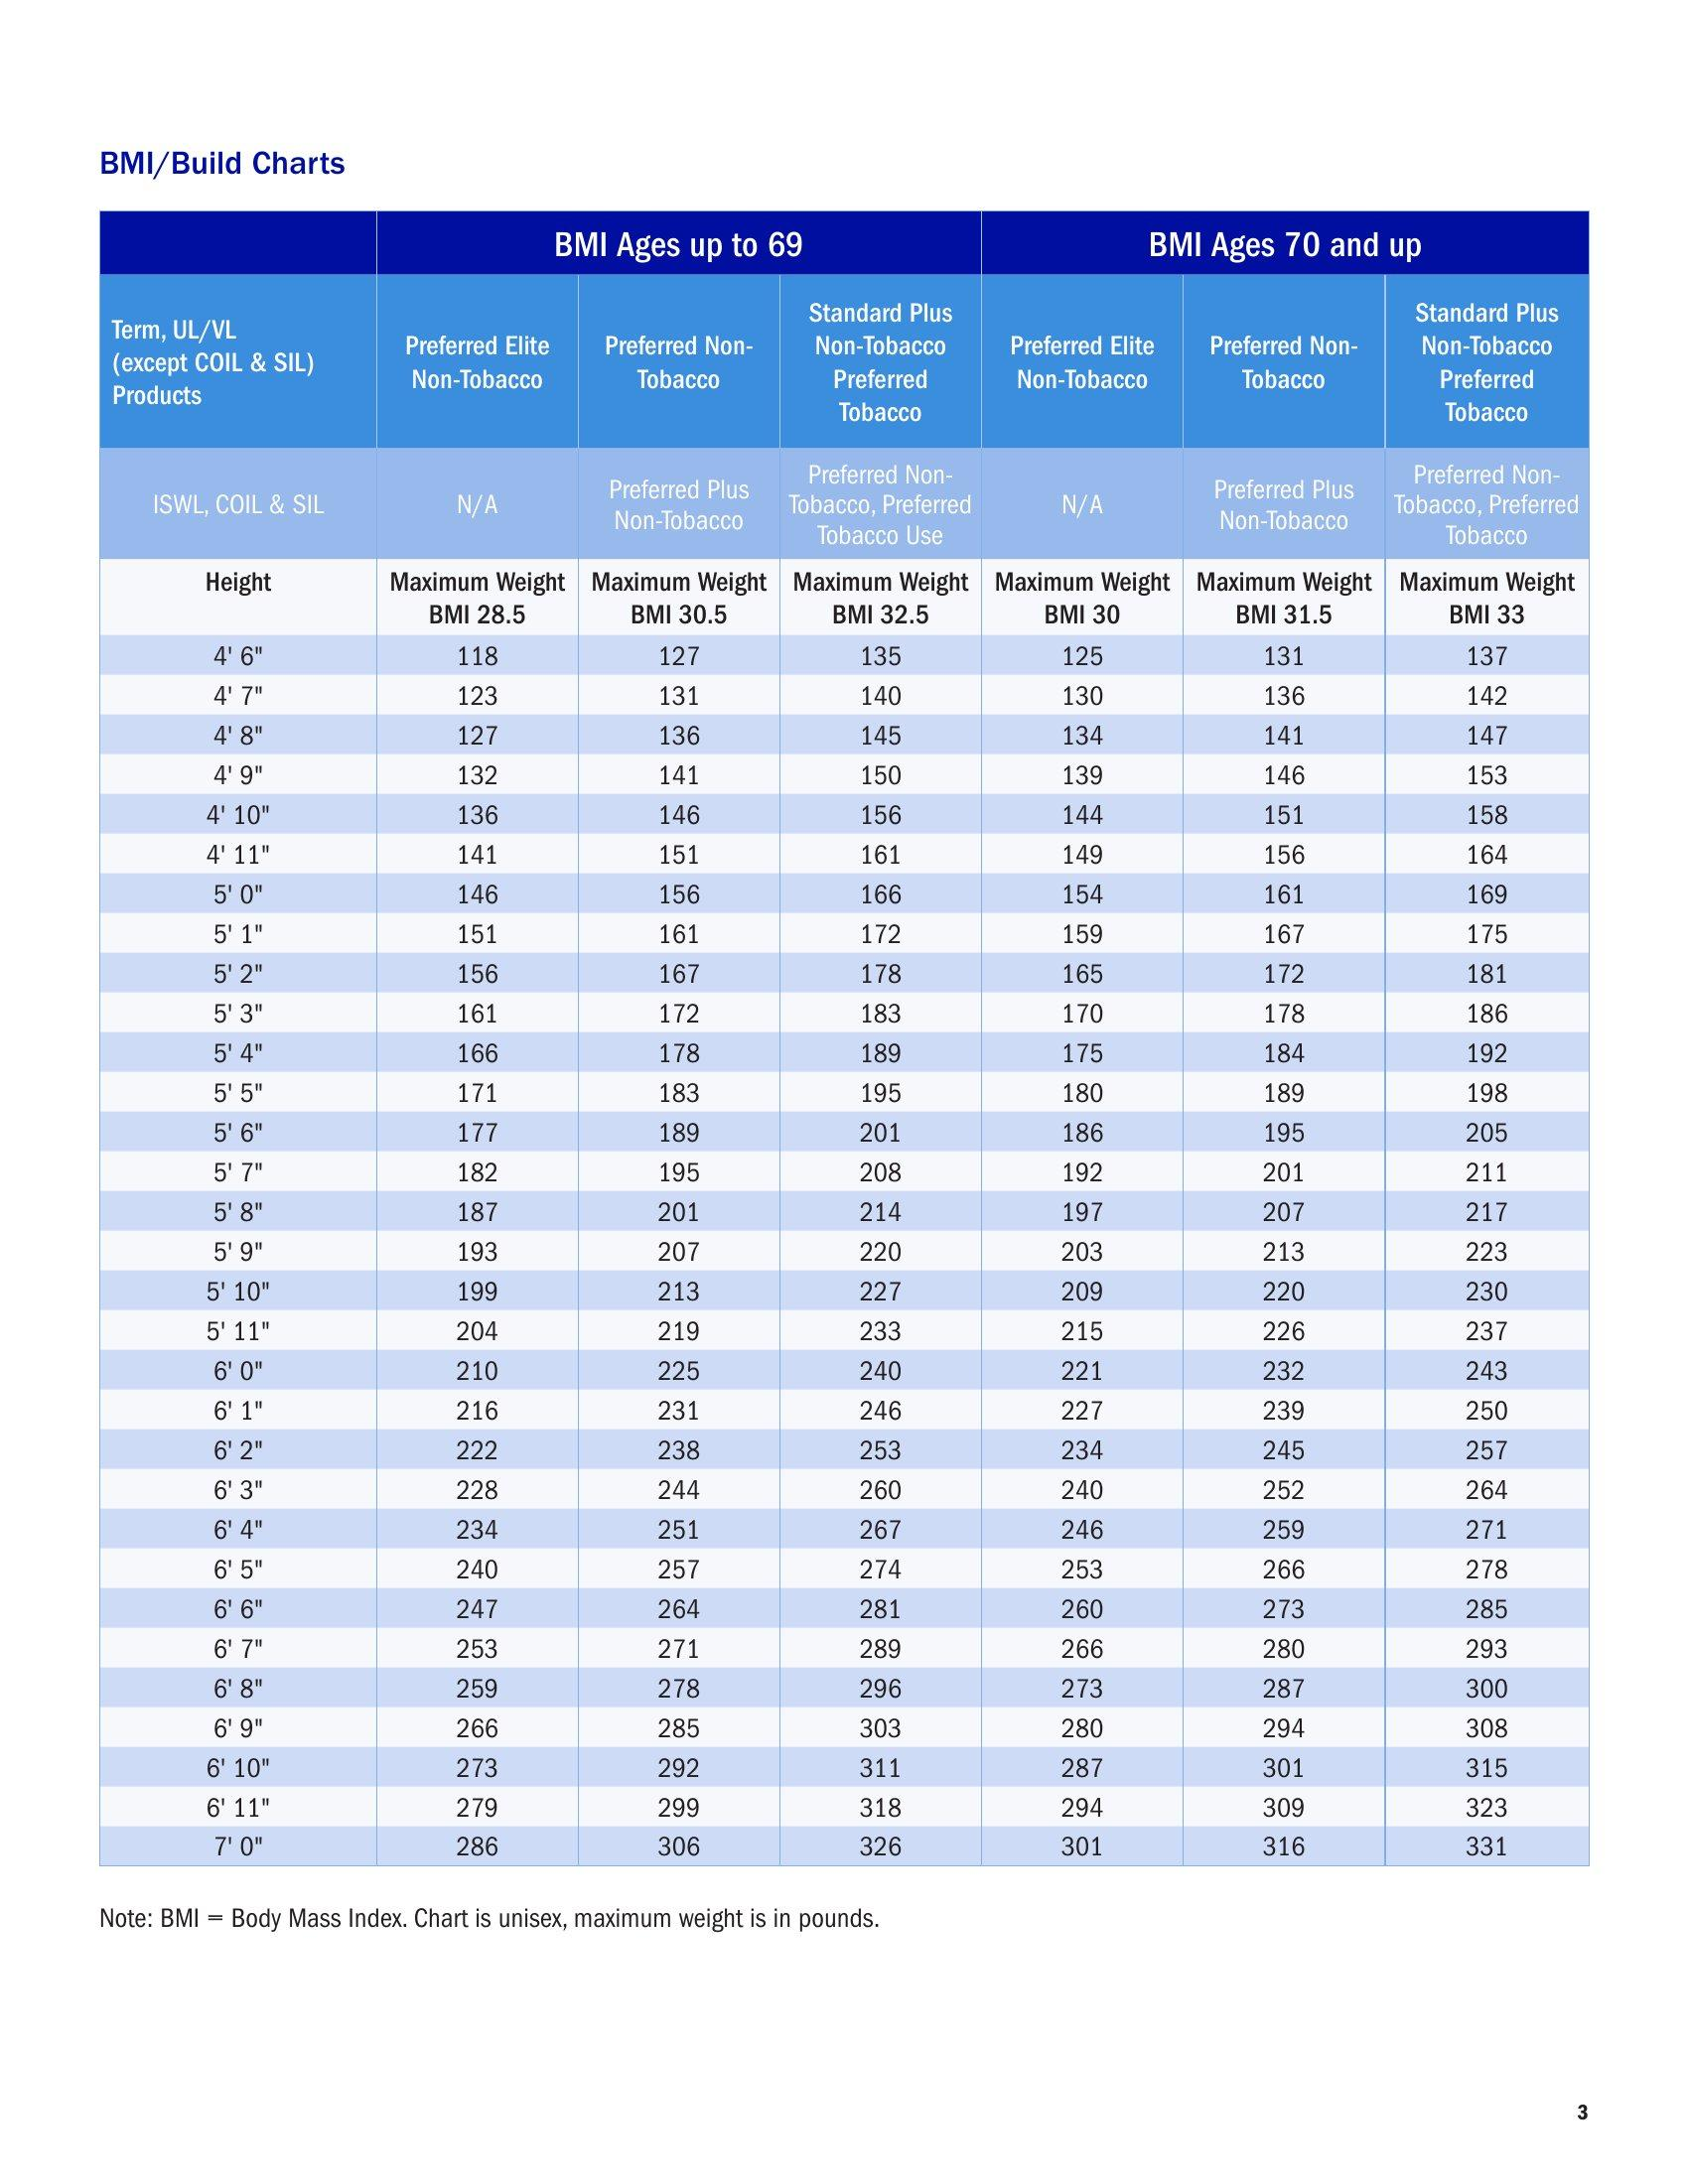
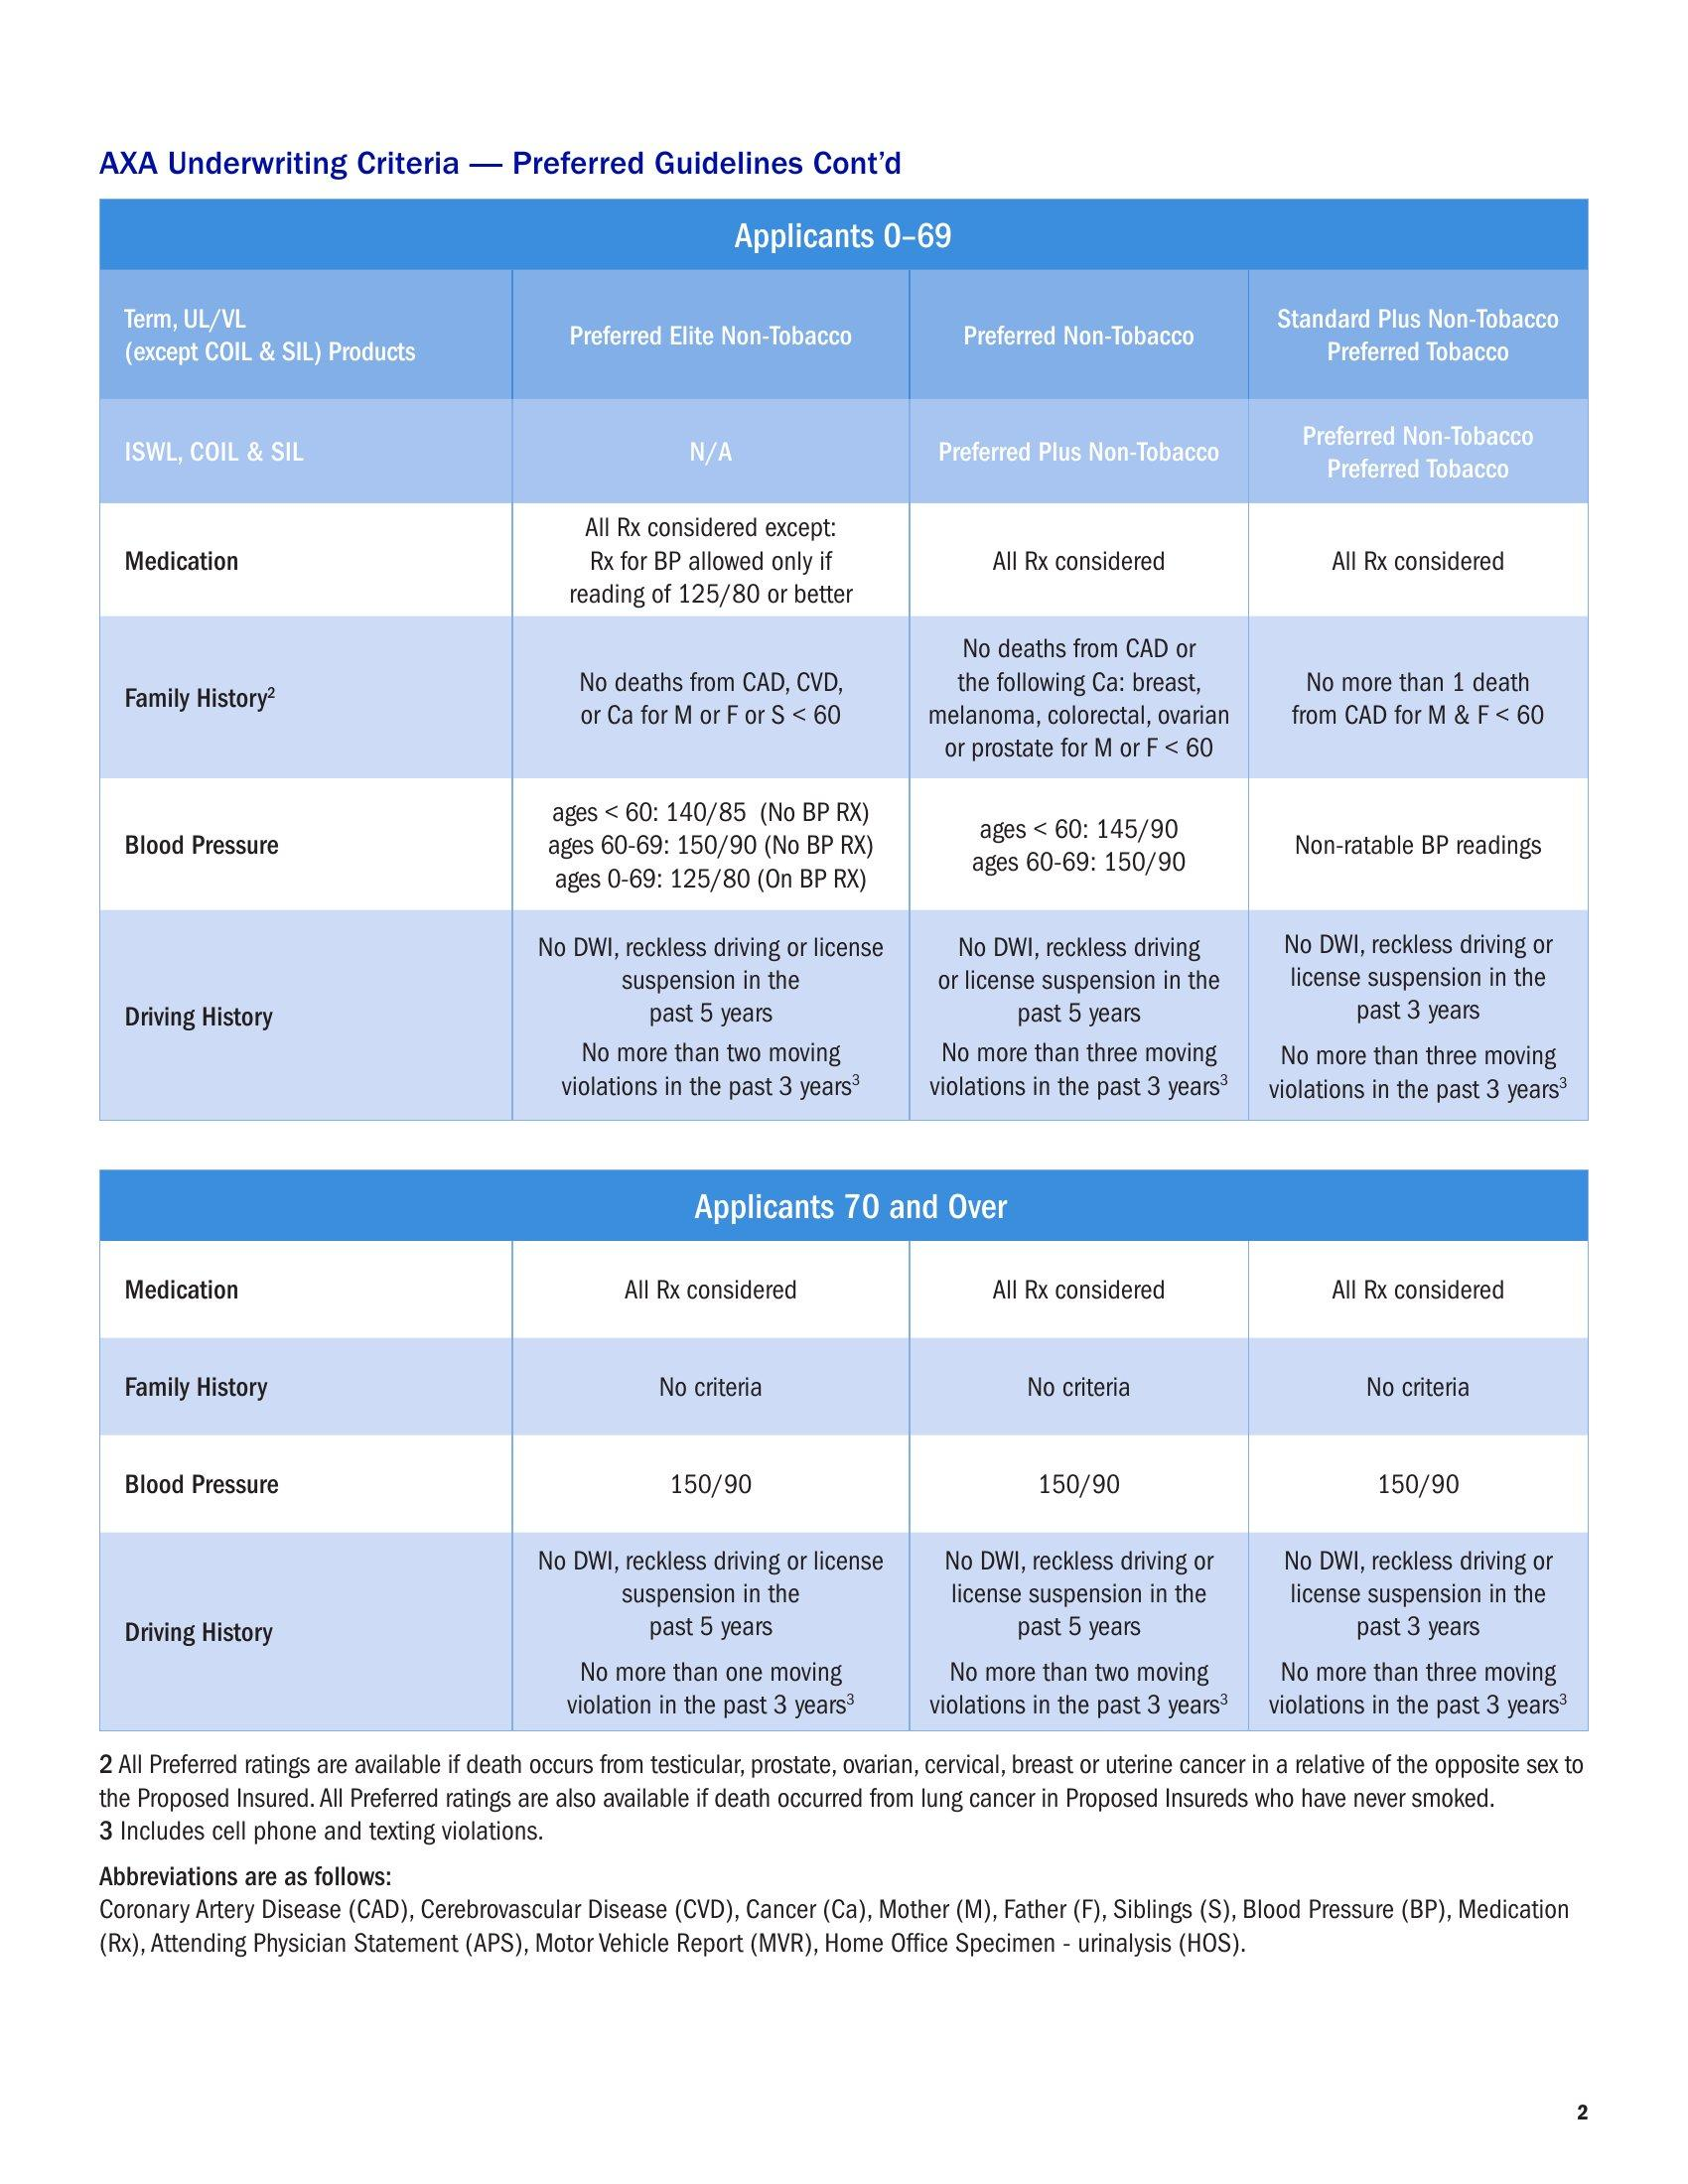
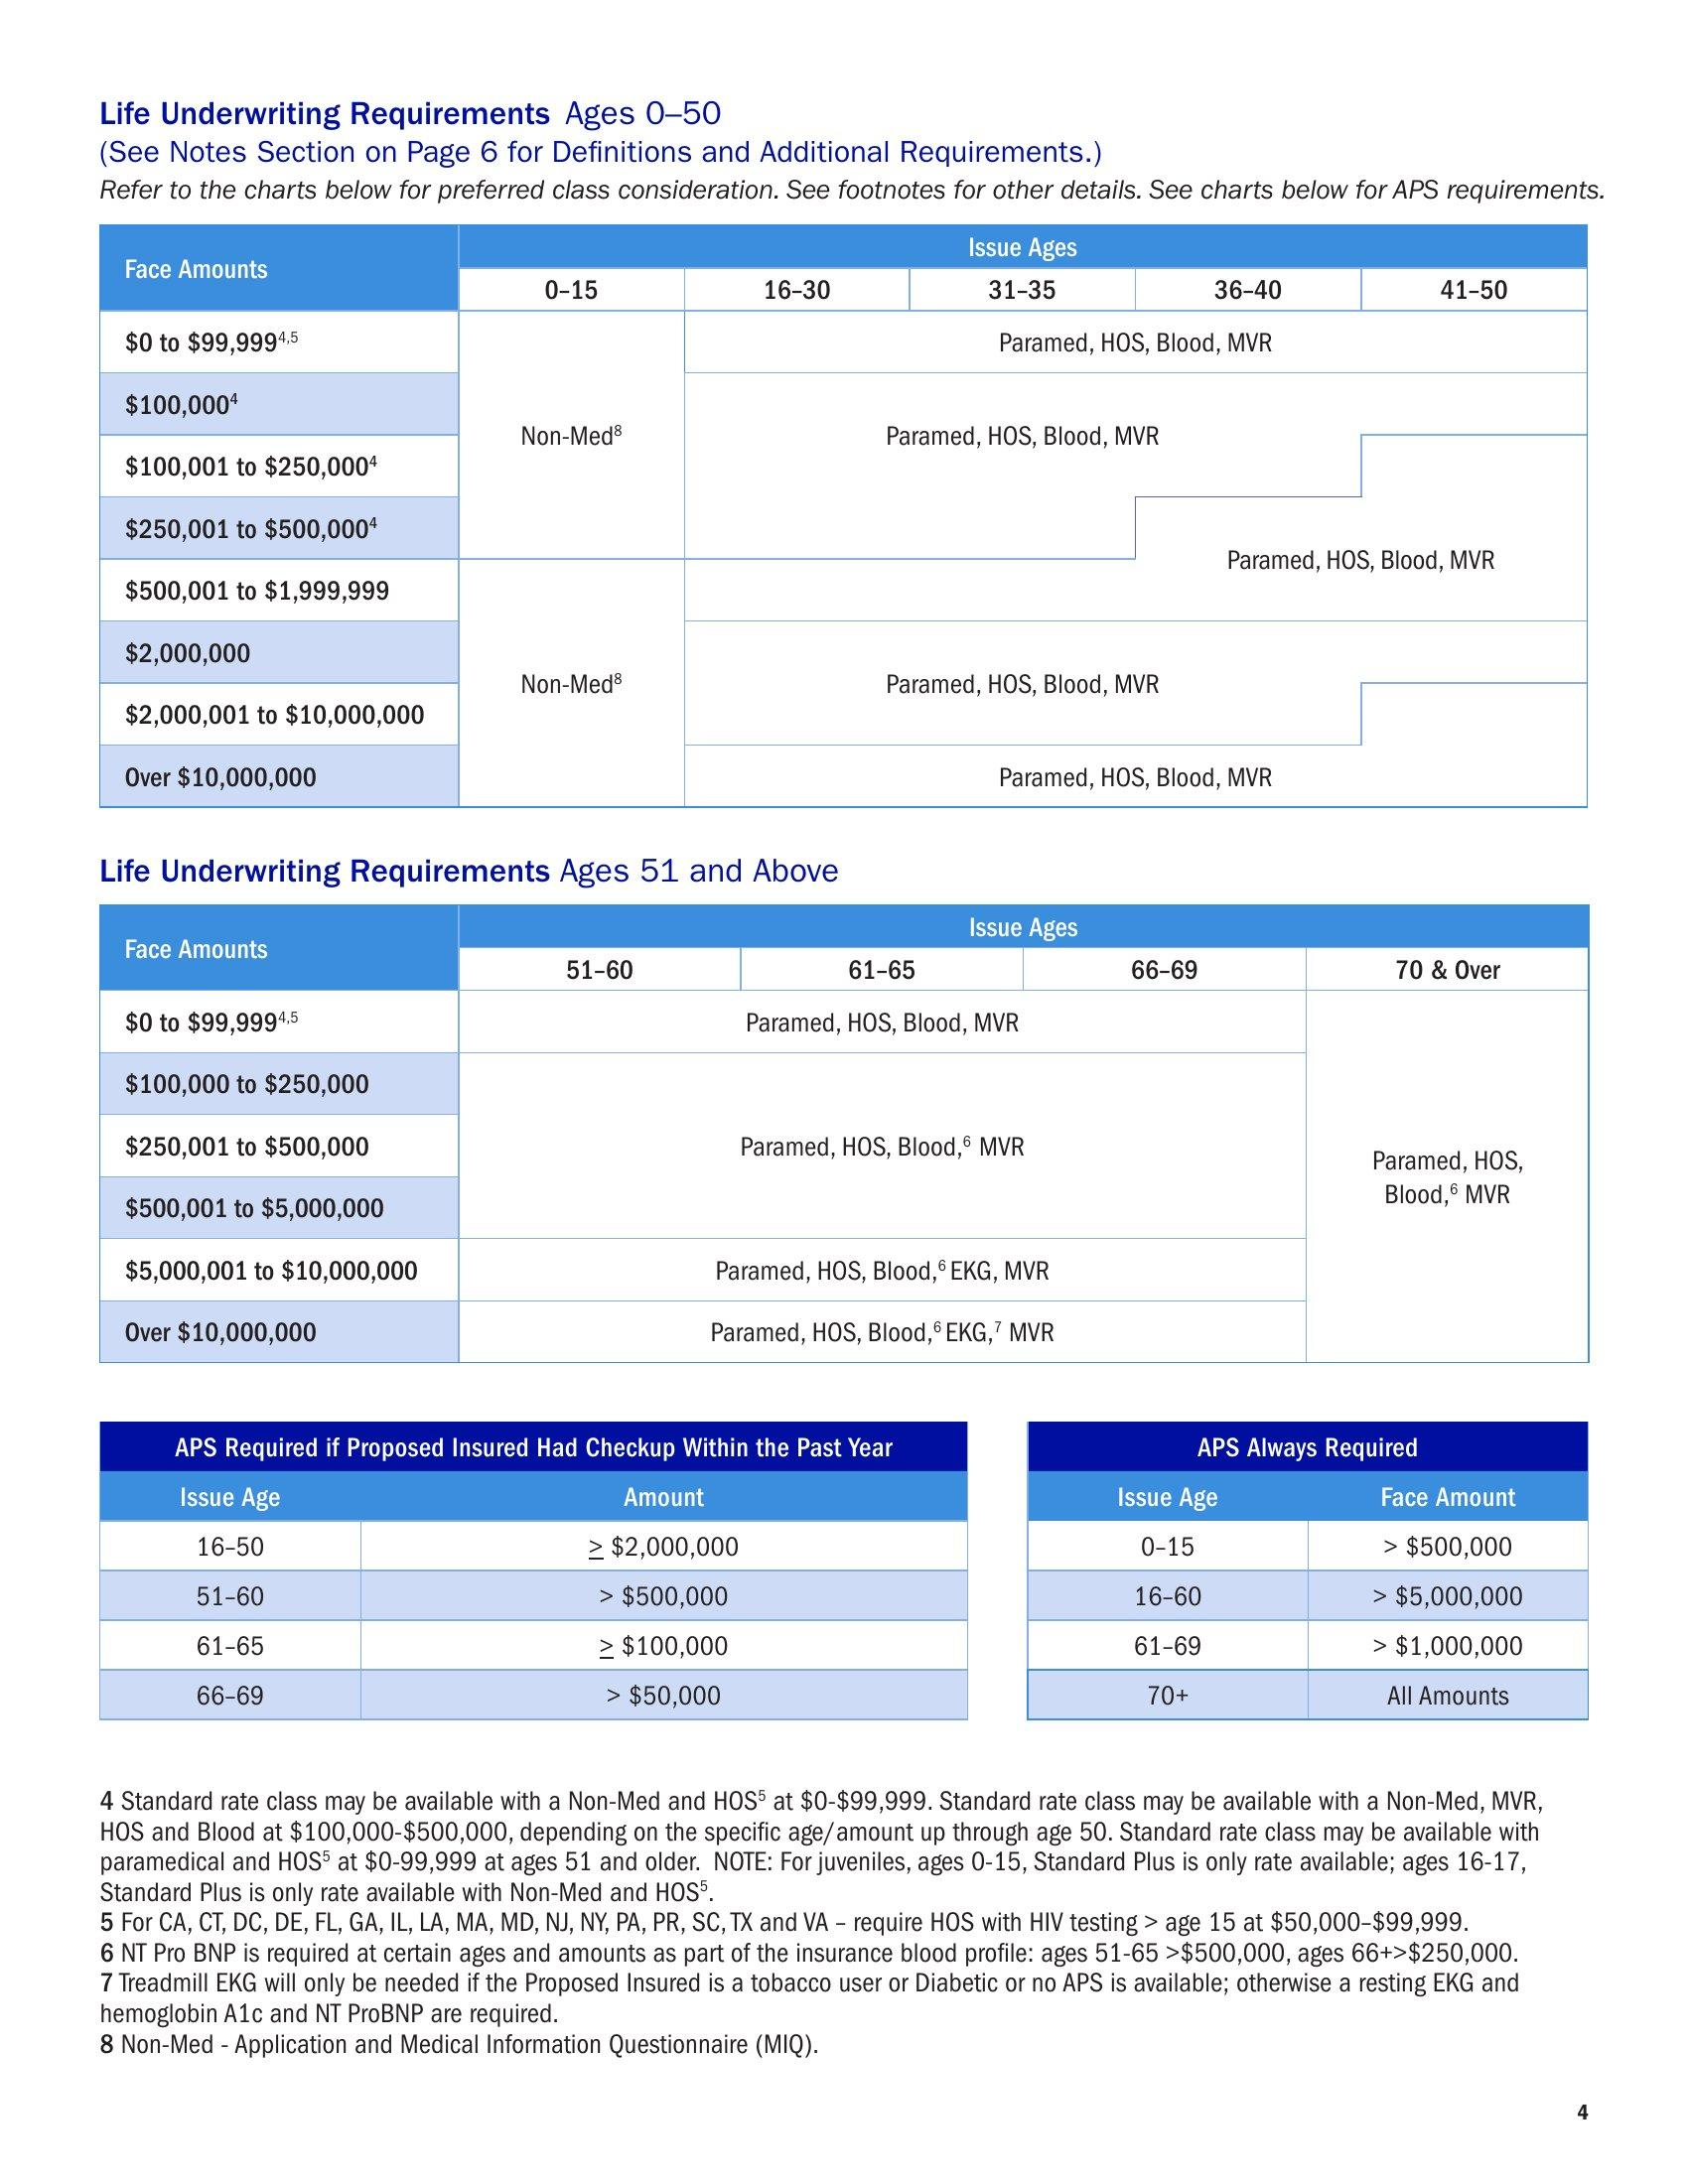
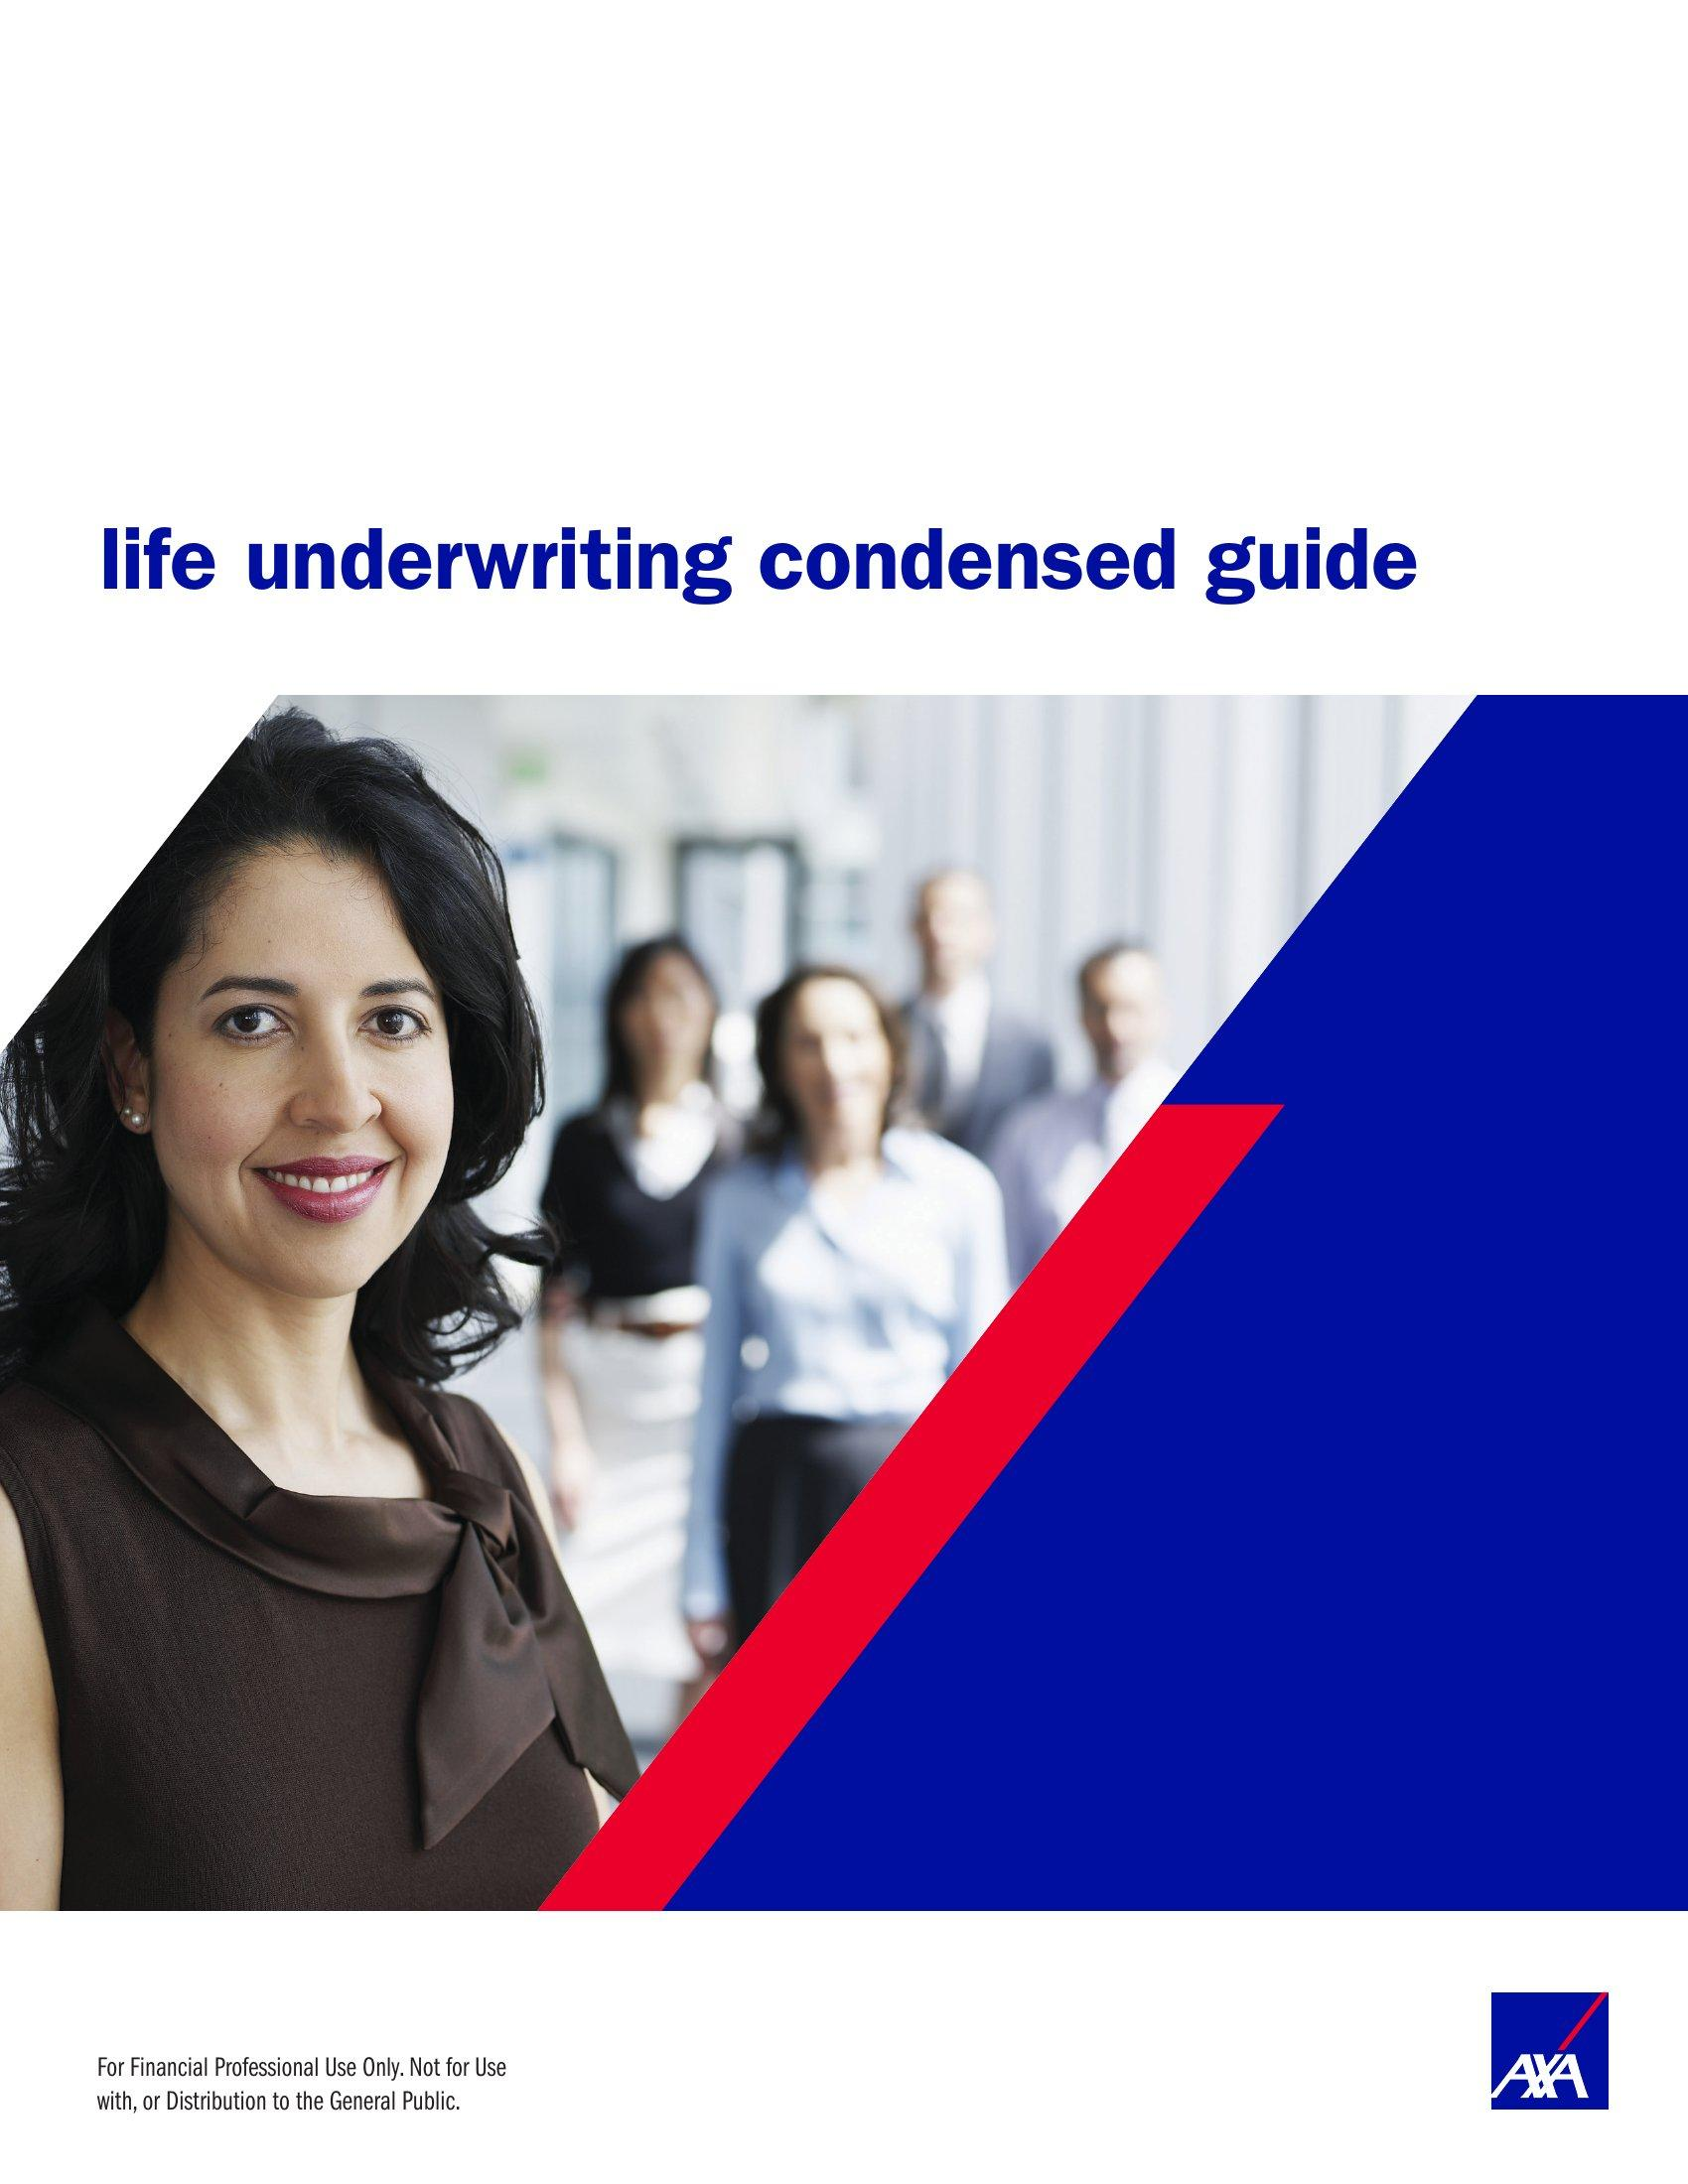
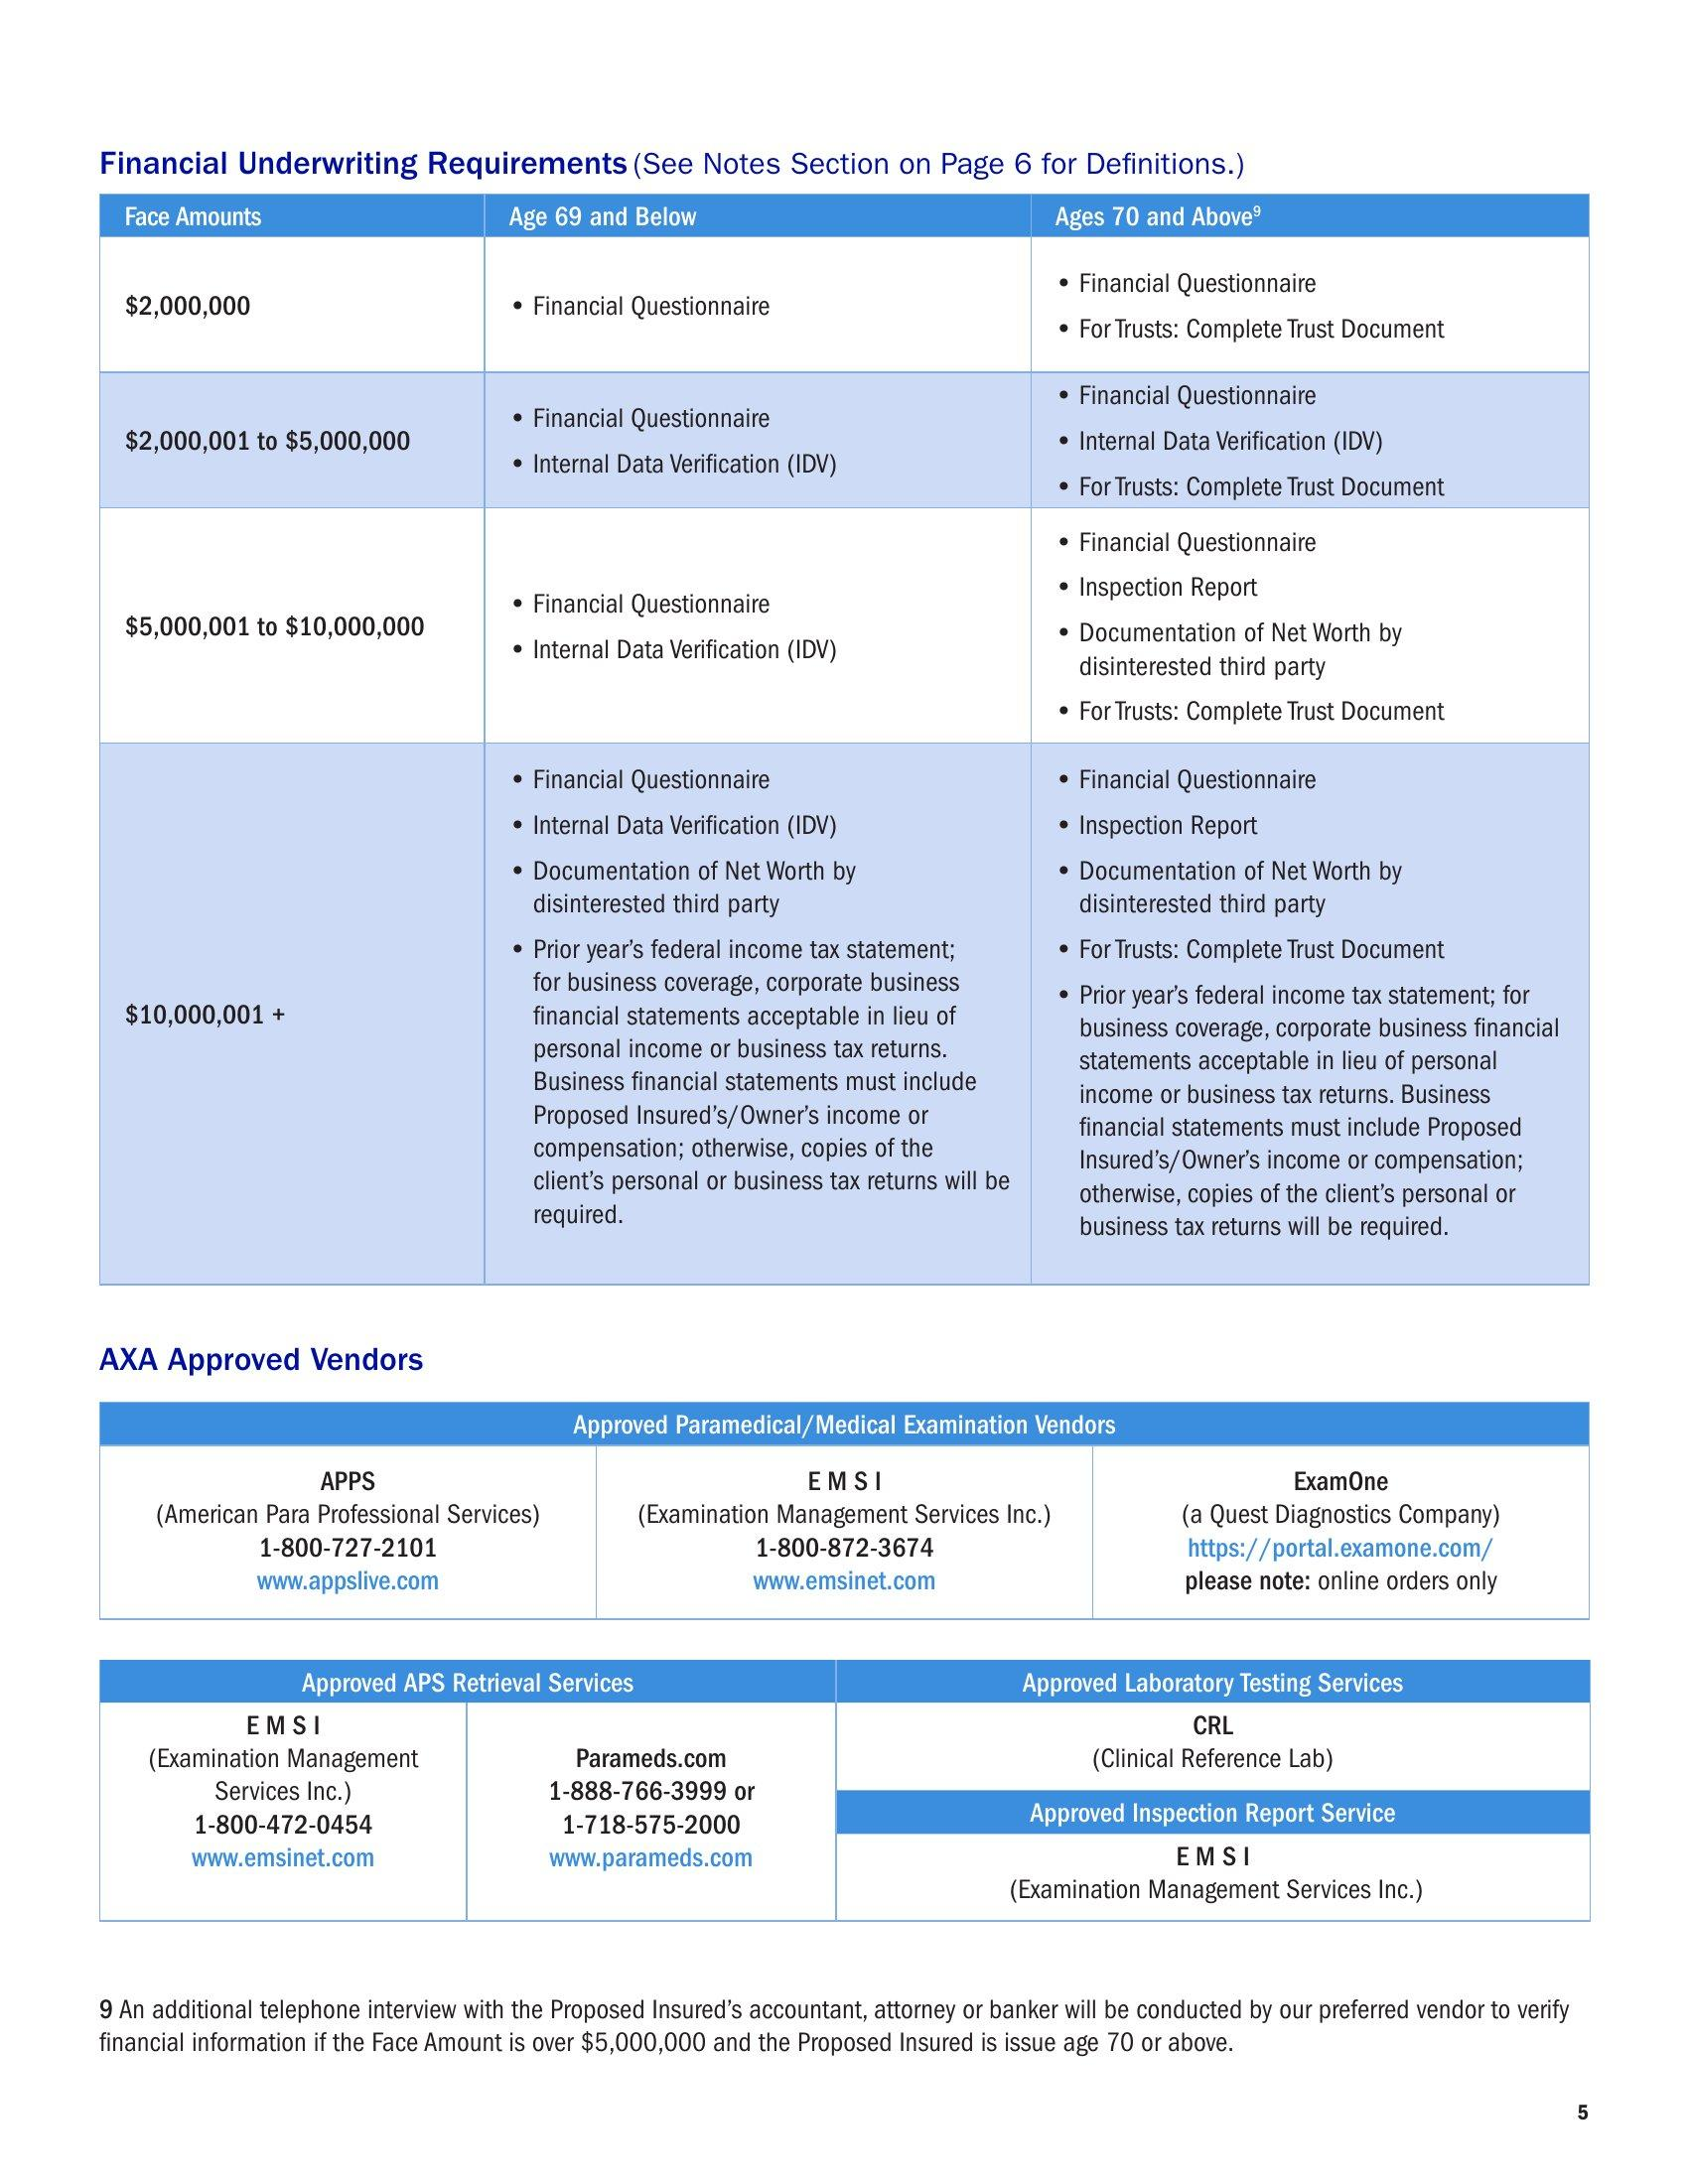
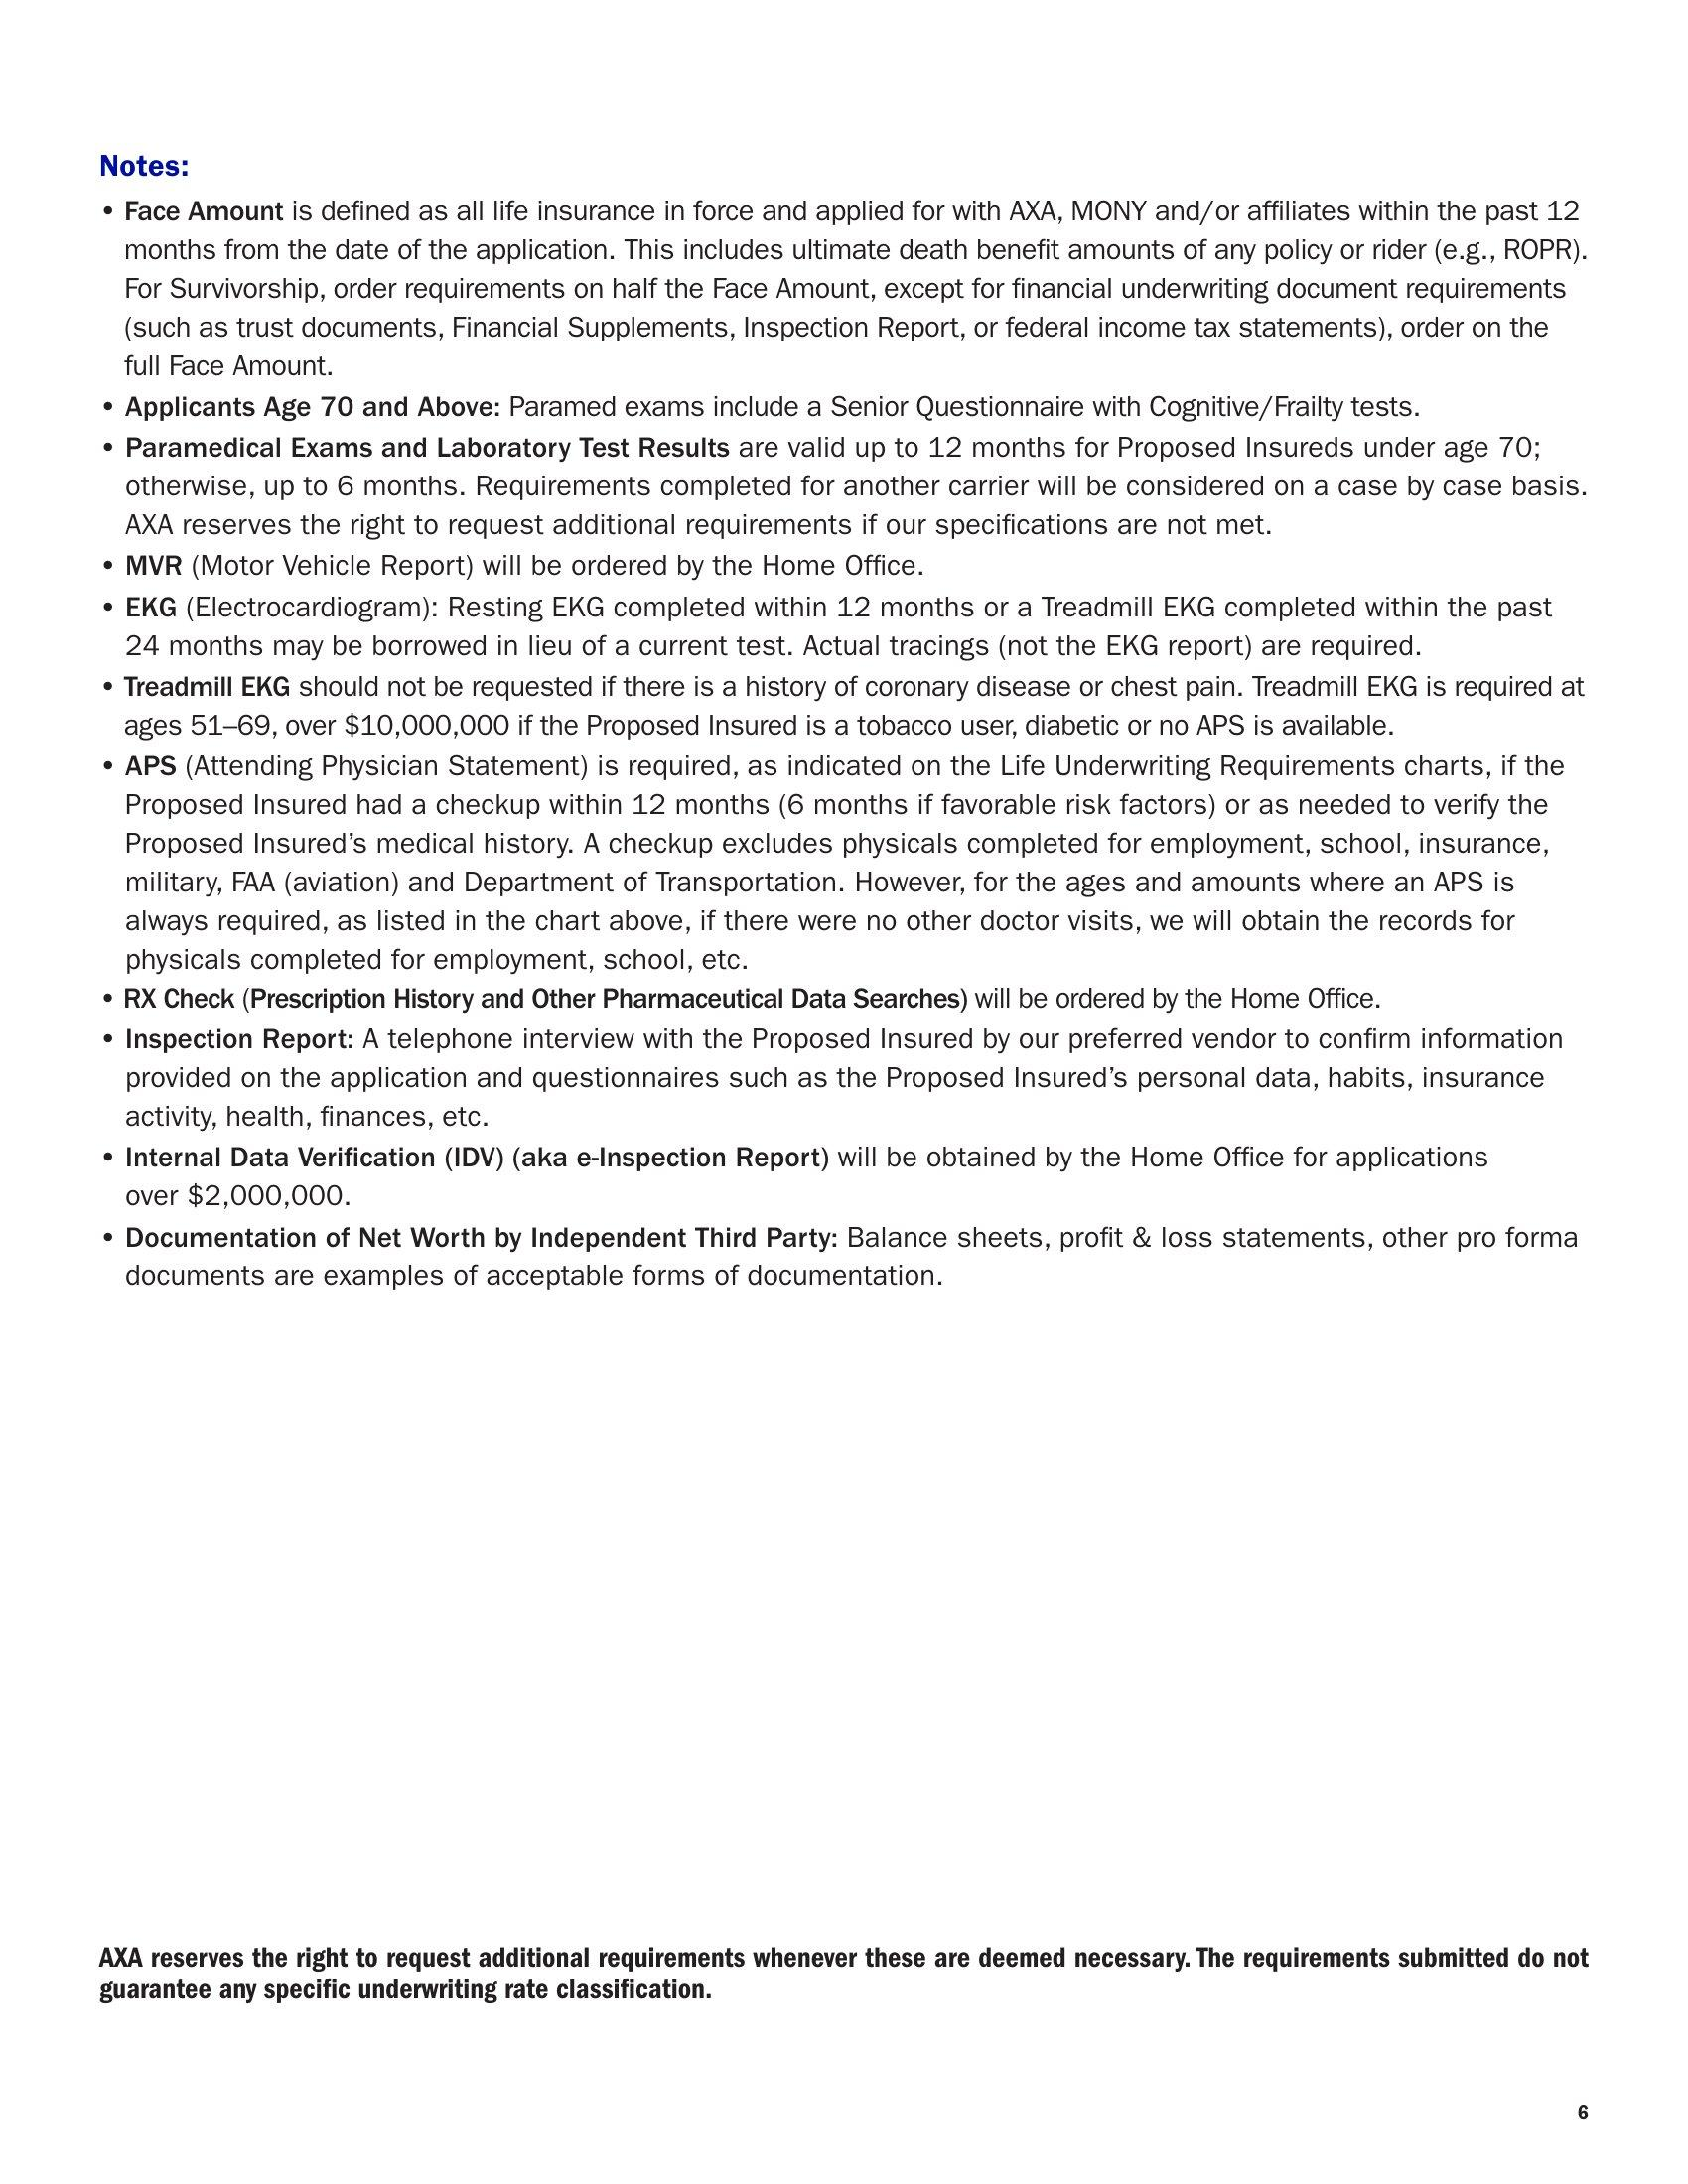

{'doc_id': 'axa-uw.pdf', 'chunk_start': 4, 'chunk_end': 12, 'score': np.float64(2.5314333774888444), 'content': 'Document context: the following excerpt is from a document titled \'Life Underwriting Condensed Guide\'. This document is about: the underwriting guidelines, requirements, and criteria for life insurance policies issued by AXA, including preferred risk classifications, medical and financial underwriting standards, and procedural details for different applicant age groups and coverage amounts.\n\nA table titled "AXA Underwriting Criteria — Preferred Guidelines" with a header row "All Applicants" spanning four columns. The columns are labeled: "Term, UL/VL (except COIL & SIL) Products", "Preferred Elite Non-Tobacco", "Preferred Non-Tobacco", and "Standard Plus Non-Tobacco Preferred Tobacco¹". The rows detail criteria for: \n- ISWL, COIL & SIL: N/A under Preferred Elite Non-Tobacco; "Preferred Plus Non-Tobacco" under Preferred Non-Tobacco; "Preferred Non-Tobacco Preferred Tobac

In [2]:
llm = AzureOpenAIChatAPI(model='gpt-4.1-mini')
embedding_model = AzureOpenAIEmbedding(model='text-embedding-3-small')
reranker = AzureCohereReranker(model='Cohere-rerank-v3.5')

kb_id = "axa-uw"
file_path = "../tests/data/axa-uw.pdf"
doc_id = os.path.basename(file_path)

kb = KnowledgeBase(kb_id=kb_id, storage_directory="./axa-uw", embedding_model=embedding_model,
                   reranker=reranker, auto_context_model=llm)

kb.add_document(doc_id=doc_id, file_path=file_path,
                file_parsing_config={
                    "use_vlm": True,
                    "always_save_page_images": True,
                    "vlm_config": {
                        "provider": "azure_openai",
                        "model": "gpt-4.1-mini",
                    }
                },
                semantic_sectioning_config={
                    "llm_provider": "azure_openai",
                    "model": "gpt-4.1-mini",
                })

search_queries = [
    "What are the criterias for applicants to be categorized as 'Preferred Elite Non-Tobacco'?"]
results = kb.query(search_queries)
for segment in results:
  print(segment)

In [3]:
# Configure chat parameters
chat_params = {
    "kb_ids": [kb_id],
    "model": "azure/gpt-4.1-mini",
    "temperature": 0,
    "system_message": "You are a helpful assistant specialized in technical documentation",
    "auto_query_model": "azure/gpt-4.1-mini",
    "target_output_length": "medium"
}

# Initialize chat thread database (SQLite in this case)
chat_thread_db = BasicChatThreadDB()

# Create the thread
thread_id = create_new_chat_thread(chat_params, chat_thread_db)

chat_thread_params:  {'kb_ids': ['axa-uw'], 'model': 'azure/gpt-4.1-mini', 'temperature': 0, 'system_message': 'You are a helpful assistant specialized in technical documentation', 'auto_query_model': 'azure/gpt-4.1-mini', 'target_output_length': 'medium', 'thread_id': 'b0e4f140-aa82-449e-ae53-f671562900a0', 'supp_id': '', 'auto_query_guidance': '', 'max_chat_history_tokens': 8000, 'rse_params': {}}


In [5]:
# Create input with optional metadata filter
response_input = ChatResponseInput(
    user_input="What are the blood pressure requirements for applicants to be categorized as 'Preferred Elite Non-Tobacco'? Please consider of all ages.",
    metadata_filter={
        "field": "doc_id",
        "operator": "equals",
        "value": doc_id
    }
)

# Create the knowledge base instances
knowledge_bases = {
    kb_id: KnowledgeBase(kb_id=kb_id, storage_directory="./axa-uw")
}

# Get response
response = get_chat_thread_response(
    thread_id=thread_id,
    get_response_input=response_input,
    chat_thread_db=chat_thread_db,
    knowledge_bases=knowledge_bases  # Dictionary of your knowledge base instances
)

# Access the response content and citations
print(response["model_response"]["content"])
for citation in response["model_response"]["citations"]:
    print(f"Source: {citation['doc_id']}, Page: {citation['page_number']}")

2025-06-13 13:16:55,157 - dsrag.chat - INFO - Starting chat response
2025-06-13 13:16:55,158 - dsrag.chat - DEBUG - Chat parameters
2025-06-13 13:16:55,192 - instructor - DEBUG - Patching `client.chat.completions.create` with mode=<Mode.TOOLS: 'tool_call'>
2025-06-13 13:16:55,196 - httpcore.connection - DEBUG - close.started
2025-06-13 13:16:55,198 - httpcore.connection - DEBUG - close.complete
2025-06-13 13:16:55,205 - instructor - DEBUG - Instructor Request: mode.value='tool_call', response_model=<class 'dsrag.chat.auto_query.Queries'>, new_kwargs={'messages': [{'role': 'system', 'content': [{'type': 'text', 'text': 'You are a query generation system. Please generate one or more search queries (up to a maximum of 5) based on the provided user input. DO NOT generate the answer, just queries. You must specify the knowledge base you want to use for each query by providing the knowledge_base_id.\n\nEach of the queries you generate will be used to search a knowledge base for information t

NON-STREAMING RESPONSE


2025-06-13 13:16:55,629 - httpcore.connection - DEBUG - connect_tcp.complete return_value=<httpcore._backends.sync.SyncStream object at 0x7f9038227dd0>
2025-06-13 13:16:55,630 - httpcore.connection - DEBUG - start_tls.started ssl_context=<ssl.SSLContext object at 0x7f90380aecd0> server_hostname='aoaisec.openai.azure.com' timeout=5.0
2025-06-13 13:16:56,278 - httpcore.connection - DEBUG - start_tls.complete return_value=<httpcore._backends.sync.SyncStream object at 0x7f90380d4470>
2025-06-13 13:16:56,279 - httpcore.http11 - DEBUG - send_request_headers.started request=<Request [b'POST']>
2025-06-13 13:16:56,280 - httpcore.http11 - DEBUG - send_request_headers.complete
2025-06-13 13:16:56,280 - httpcore.http11 - DEBUG - send_request_body.started request=<Request [b'POST']>
2025-06-13 13:16:56,281 - httpcore.http11 - DEBUG - send_request_body.complete
2025-06-13 13:16:56,281 - httpcore.http11 - DEBUG - receive_response_headers.started request=<Request [b'POST']>
2025-06-13 13:16:57,105 - 

Search queries by KB: {'axa-uw': ['blood pressure requirements for Preferred Elite Non-Tobacco category for all ages']}


2025-06-13 13:16:57,490 - httpcore.connection - DEBUG - connect_tcp.complete return_value=<httpcore._backends.sync.SyncStream object at 0x7f90380f20c0>
2025-06-13 13:16:57,490 - httpcore.connection - DEBUG - start_tls.started ssl_context=<ssl.SSLContext object at 0x7f9039dfcd50> server_hostname='aoaisec.openai.azure.com' timeout=5.0
2025-06-13 13:16:58,022 - httpcore.connection - DEBUG - start_tls.complete return_value=<httpcore._backends.sync.SyncStream object at 0x7f903808a090>
2025-06-13 13:16:58,023 - httpcore.http11 - DEBUG - send_request_headers.started request=<Request [b'POST']>
2025-06-13 13:16:58,024 - httpcore.http11 - DEBUG - send_request_headers.complete
2025-06-13 13:16:58,024 - httpcore.http11 - DEBUG - send_request_body.started request=<Request [b'POST']>
2025-06-13 13:16:58,025 - httpcore.http11 - DEBUG - send_request_body.complete
2025-06-13 13:16:58,029 - httpcore.http11 - DEBUG - receive_response_headers.started request=<Request [b'POST']>
2025-06-13 13:16:58,364 - 

The blood pressure requirements for applicants to be categorized as 'Preferred Elite Non-Tobacco' are as follows:

- For applicants under age 60: 140/85 with no blood pressure medication (BP RX).
- For applicants aged 60 to 69: 150/90 with no blood pressure medication.
- For applicants aged 0 to 69 who are on blood pressure medication: 125/80.
- For applicants aged 70 and over: 150/90 (no distinction based on medication).

These requirements apply to ensure applicants meet the criteria for the 'Preferred Elite Non-Tobacco' category across all ages.
Source: axa-uw.pdf, Page: 3
